In [31]:
import torch
import random
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageFile, Image
import cv2

from CPS import CPS
#from CelebDataset import CelebDataset
#from MyModels import GeneratorModel, DiscriminatorModel
import imageio as imageio

# 코드 실행결과의 동일성을 위해 무작위 시드를 설정합니다
manualSeed = 999
#manualSeed = random.randint(1, 10000) # 만일 새로운 결과를 원한다면 주석을 없애면 됩니다
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


Random Seed:  999


In [32]:
#GPU Check

ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device,"is available!")

cuda:0 is available!


In [33]:
# DATA set check and load

transform = transforms.Compose([
                transforms.Resize(64),
                transforms.CenterCrop(64),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])
dataset = CPS('images/CPS_Dog_Cataract_Rand', transform=transform)
dataloader = DataLoader(dataset, shuffle=True, batch_size=64, num_workers=2)

torch.Size([64, 3, 64, 64])


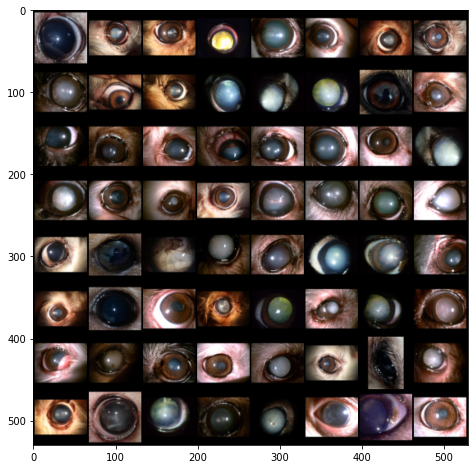

In [34]:
# view function and check the sample imgs

def view_samples(images):
    img = torchvision.utils.make_grid(images, padding=2, normalize=True)
    img = img.cpu().numpy()
    plt.figure(figsize = (8, 8))
    plt.imshow(np.transpose(img, (1,2,0)))
    plt.show()
    
test = iter(dataloader)
sample = next(test)
print(sample.size())
view_samples(sample)

In [35]:
# save the progress of learning result pics

def save_progress(images, epoch, step):
    img = torchvision.utils.make_grid(images, padding=2, normalize=True)
    img = img.cpu().numpy()
    img = np.transpose(img, (1,2,0))
    img = np.uint8(img*255)
    imageio.imwrite(f"Results/LSGAN_Cataract/{epoch}-{step}.jpg", img)

In [36]:
# save the model's state

def save_model_state(model, optimizer, loss, epoch, name):
    model_path = f"saved_models/{name}{epoch}.pt"
    state_dict = {
        'epoch' : epoch,
        'model_state_dict' : model.state_dict(),
        'opt_state_dict' : optimizer.state_dict(),
        'training_loss' : loss,
    }
    torch.save(state_dict, model_path)

In [37]:
# load the saved model

def load_model_state(model, filename):
    model_info = torch.load(f"saved_models/{filename}.pt")
    optimizer = torch.optim.Adam(model.parameters())
    optimizer.load_state_dict(model_info["opt_state_dict"])
    model.load_state_dict(model_info["model_state_dict"])
    return model, optimizer

In [38]:
# making loss graph function

def plot_losses(gen, dis):
    fig = plt.figure(figsize=(10, 5))
    ax = plt.subplot(111)
    ax.plot(gen, label="Generator")
    ax.plot(dis, label="Discriminator")
    plt.title("PCA_GAN Gen/Dis losses")
    ax.legend()
    plt.show()

In [39]:
# initialize step

n_z = 100 # 잠재공간 벡터 크기(생성자 입력값 크기)
n_c = 3 # 이미지 채널 갯수(RGB)
n_feature_maps_g = 64 # 생성자의 특징 맵 크기
n_feature_maps_d = 64 # 구분자의 특징 맵 크기
epochs = 300

fixed_noise = torch.randn(64, n_z, 1, 1).to(device)
torch.save(fixed_noise, "fixed_noise.pt")

In [40]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class DiscriminatorModel(nn.Module):
    def __init__(self, n_c, n_fmps):
        super(DiscriminatorModel, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(n_c, n_fmps, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(n_fmps, n_fmps*2, 4, stride=2, padding=1),
            nn.BatchNorm2d(n_fmps*2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(n_fmps*2, n_fmps*4, 4, stride=2, padding=1),
            nn.BatchNorm2d(n_fmps*4),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(n_fmps*4, n_fmps*8, 4, stride=2, padding=1),
            nn.BatchNorm2d(n_fmps*8),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(n_fmps * 8, 1, 4, stride=1, padding=0),
        )
        self.linear = nn.Linear(1, 1)
        self.net.apply(weights_init)
        self.linear.apply(weights_init)
    def forward(self, x):
        x = self.net(x)
        #print(x.shape)
        x = self.linear(x)
        #print(x.shape)
        return x.view(-1, 1, 1, 1)

In [41]:
class GeneratorModel(nn.Module):
    def __init__(self, n_z, n_fmps, n_c):
        super(GeneratorModel, self).__init__()
        self.n_z = n_z
        self.net = nn.Sequential(
            nn.ConvTranspose2d(self.n_z, n_fmps*8, 4, 1, 0),
            nn.BatchNorm2d(n_fmps*8),
            nn.LeakyReLU(0.2, True),
            nn.ConvTranspose2d(n_fmps*8, n_fmps*4, 4, 2, 1),
            nn.BatchNorm2d(n_fmps*4),
            nn.LeakyReLU(0.2, True),
            nn.ConvTranspose2d(n_fmps*4, n_fmps*2, 4, 2, 1),
            nn.BatchNorm2d(n_fmps*2),
            nn.LeakyReLU(0.2, True),
            nn.ConvTranspose2d(n_fmps*2, n_fmps*1, 4, 2, 1),
            nn.BatchNorm2d(n_fmps*1),
            nn.LeakyReLU(0.2, True),
            nn.ConvTranspose2d(n_fmps, n_c, 4, 2, 1),
            nn.Tanh()
        )
        self.net.apply(weights_init)

    def forward(self, x):
        x = x.view(-1, self.n_z, 1, 1)
        x = self.net(x)
        return x

In [42]:
g_losses = [] # 생성자 loss
d_losses = [] # 구분자 loss

Dis = DiscriminatorModel(n_c, n_feature_maps_d).to(device) # 구분자 모델 생성
Gen = GeneratorModel(n_z, n_feature_maps_g, n_c).to(device) # 생성자 모델 생성

lr_g = 2e-4 # 생성자 learning rate 설정
lr_d = 2e-4 # 구분자 learning rate 설정
Dis_opt = optim.Adam(Dis.parameters(), lr=lr_d, betas=(0.5, 0.999)) # 구분자 옵티마이저 설정
Gen_opt = optim.Adam(Gen.parameters(), lr=lr_g, betas=(0.5, 0.999)) # 생성자 옵티마이저 설정
criterion = nn.MSELoss()

len(dataloader)
checkpoint = int(len(dataloader)/10)

d_running_loss = 0.
g_running_loss = 0.


In [43]:
print(Dis)
print(checkpoint)

DiscriminatorModel(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
  )
  (linear): Linear(in_features=1, out_features=1, bias=True)
)
10


In [44]:
print(Gen)

GeneratorModel(
  (net): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2,

In [45]:
# Training part

for e in range(1, epochs+1):
    print(f"Epoch {e} started.")
    for i, batch in enumerate(dataloader, 1):
        
        batch_size = batch.size(0)
        real_image = batch.to(device)

        fake_label = torch.zeros(batch_size, 1, 1, 1).to(device)
        real_label = torch.ones(batch_size, 1, 1, 1).to(device)

        Dis.zero_grad()
        D_x = Dis(real_image)
        D_x_loss = criterion(D_x, real_label)
        d_running_loss += D_x_loss.item()
        D_x_loss.backward()

        z = torch.randn(batch_size, n_z, 1, 1).to(device)  # 일반적인 noise

        G_z = Gen(z)
        D_G_z = Dis(G_z.detach())
        D_G_z_loss = criterion(D_G_z, fake_label)
        d_running_loss += D_G_z_loss.item()
        D_G_z_loss.backward()
        
        Dis_opt.step()
        
        Gen.zero_grad()
        G_z = Gen(z)
        D_G_z = Dis(G_z)
        G_z_loss = criterion(D_G_z, real_label)
        g_running_loss += G_z_loss.item()
        
        G_z_loss.backward()    
        Gen_opt.step()
        
        if i % checkpoint == 0:
            
            g_current_loss = g_running_loss/checkpoint
            d_current_loss = d_running_loss/checkpoint
            g_losses.append(g_current_loss)
            d_losses.append(d_current_loss)
            print(f"[Generator loss: {g_current_loss}, Discriminator loss: {d_current_loss}]")

            if (i * checkpoint) % 10 == 0:
                fixed_z_images = Gen(fixed_noise).detach()
                save_progress(fixed_z_images, e, i//checkpoint)
            
            g_running_loss = 0.
            d_running_loss = 0.

Epoch 1 started.
[Generator loss: 1.5542725771665573, Discriminator loss: 0.27133985981345177]
[Generator loss: 1.8076456569135189, Discriminator loss: 0.2500165323726833]
[Generator loss: 1.8895174160599708, Discriminator loss: 0.4621969636529684]
[Generator loss: 1.4697444319725037, Discriminator loss: 0.04065309981815517]
[Generator loss: 1.5717863369733096, Discriminator loss: 0.30232174238190057]
[Generator loss: 1.4795318175107242, Discriminator loss: 0.23568921247497202]
[Generator loss: 1.1219653606414794, Discriminator loss: 0.08628595313057304]
[Generator loss: 1.1145472507923841, Discriminator loss: 0.31641072649508717]


KeyboardInterrupt: 

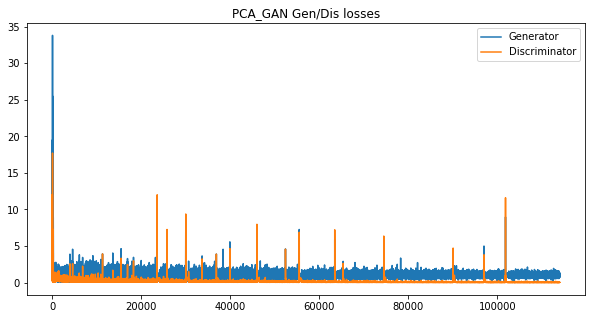

In [ ]:
plot_losses(g_losses,d_losses)

In [ ]:
avg_Gloss = np.average(g_losses)
print("Average Generator Loss:", avg_Gloss)

avg_Dloss = np.average(d_losses)
print("Average Discriminator Loss:",avg_Dloss)

Average Generator Loss: 0.9884725783042806
Average Discriminator Loss: 0.09673577705556281
